In [34]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import pretty_midi_fluidsynth as pmf

import tensorflow as tf
from tensorflow import keras

import os
from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split

# check & set device

In [35]:
# device = tf.config.list_physical_devices()
# display(device)

In [36]:
# ## Use a CPU
# try:
#     tf.config.experimental.set_visible_devices(
#         device[0],
#         device[0][1]
#     )
# except RuntimeError as e:
#     # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
#     print(e)

In [37]:
# ## Use a GPU
# try:
#     tf.config.experimental.set_visible_devices(
#         device[1],
#         device[1][1]
#     )
#     tf.config.experimental.set_memory_growth(device[1], True)
# except RuntimeError as e:
#     # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
#     print(e)

# model hyper parameter

In [38]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.experimental.AUTOTUNE

# data

## TFRecord read

In [39]:
context_description = {
    'hop_length':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'freq_width':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'octave':tf.io.FixedLenFeature([],tf.int64,
                                   default_value=0),
    'sampling_rate':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'piano_roll_fs':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'start_pitch': tf.io.FixedLenFeature([],tf.int64,
                                    default_value=0),
    'end_pitch':tf.io.FixedLenFeature([],tf.int64,
                                            default_value=0),
}

sequence_description = {
    'x': tf.io.FixedLenSequenceFeature([], tf.string),
    'y': tf.io.FixedLenSequenceFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto,
                                             context_description,
                                             sequence_description,)

In [40]:
filename = 'test_cqt-piano_roll.tfrecord'
path = os.path.join('./data',filename)

raw_ds = tf.data.TFRecordDataset(path)
parsed_ds = raw_ds.map(_parse_function)

In [41]:
for ds in parsed_ds.take(1):
    print(type(ds))
    context, sequence = ds

<class 'tuple'>


## context

In [42]:
context

{'end_pitch': <tf.Tensor: shape=(), dtype=int64, numpy=120>,
 'freq_width': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'hop_length': <tf.Tensor: shape=(), dtype=int64, numpy=441>,
 'octave': <tf.Tensor: shape=(), dtype=int64, numpy=8>,
 'piano_roll_fs': <tf.Tensor: shape=(), dtype=int64, numpy=25>,
 'sampling_rate': <tf.Tensor: shape=(), dtype=int64, numpy=44100>,
 'start_pitch': <tf.Tensor: shape=(), dtype=int64, numpy=24>}

In [43]:
hop_len = int(context['hop_length'])
freq_w = int(context['freq_width'])
octave = int(context['octave'])

sr = int(context['sampling_rate'])
fs = int(context['piano_roll_fs'])

start_pitch = int(context['start_pitch'])
end_pitch = int(context['end_pitch'])

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

pr_n_bins = end_pitch - start_pitch

window = 400

# sequence

In [44]:
cqt = tf.io.decode_raw(sequence['x'][0],
                       tf.float32
                      ).numpy().reshape(n_bins,-1)
cqt.shape

(384, 1200)

In [45]:
def show_cqt(cqt):
    if cqt.ndim == 3:
        cqt = np.squeeze(cqt,-1)
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    img = librosa.display.specshow(cqt, sr=sr,
                                   x_axis='time',
                                   y_axis='cqt_note',
                                   ax=ax,
                                   hop_length= hop_len,
                                   bins_per_octave= 12*freq_w,
                                   cmap='jet'
                                   )
    ax.set(title='Pitch axis decoration')
    fig.colorbar(img, ax=ax, format="%+2.2f")

    plt.show()

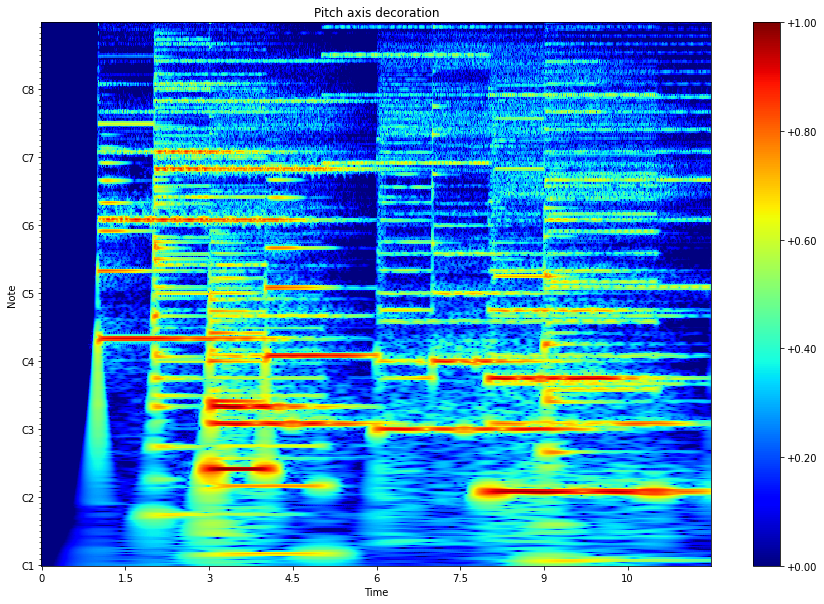

In [46]:
show_cqt(cqt)

In [47]:
piano_roll = tf.io.decode_raw(sequence['y'][0],
                              tf.float32
                             ).numpy().reshape(end_pitch-start_pitch,-1)
piano_roll.shape

(96, 300)

In [48]:
def show_pr(pr):
    if pr.ndim == 3:
        pr = np.squeeze(pr,-1)
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    img = librosa.display.specshow(
        pr,
        hop_length=1,
        sr=fs,
        ax=ax,
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    )
    fig.colorbar(img, ax=ax, format="%+2.2f")
    plt.show()

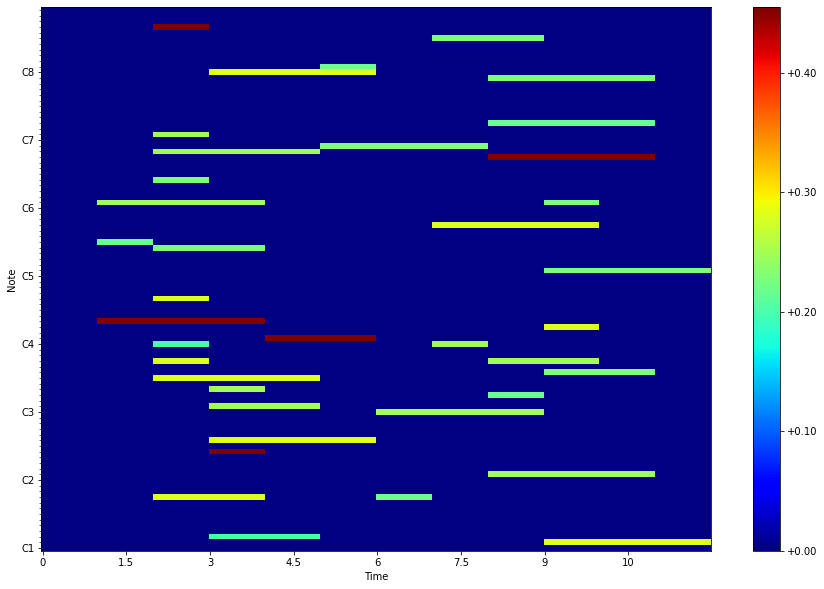

In [49]:
show_pr(piano_roll)

In [50]:
def cqt_window(cqt):
    time = cqt.shape[1]
    if time < window:
        cqt = tf.pad(cqt,([0,0],[0,window-time],[0,0]))
    elif time > window:
        cqt = cqt[:,:window]
    return cqt

def pr_window(pr):
    time = pr.shape[1]
    if time < window//4:
        pr = tf.pad(pr,([0,0],[0,window//4-time],[0,0]))
    elif time > window//4:
        pr = pr[:,:window//4]
    pr = np.where(pr==0,0,1)
    return pr

def load_cqt(data):
    raw = tf.io.decode_raw(data,tf.float32)
    cqt = tf.reshape(raw, [n_bins,-1,1])
    cqt = tf.py_function(cqt_window,
                         [cqt],
                         tf.float32)
    return tf.transpose(cqt,[1,0,2])

def load_piano_roll(data):
    raw = tf.io.decode_raw(data,tf.float32)
    piano_roll = tf.reshape(raw, [pr_n_bins,-1,1])
    piano_roll = tf.py_function(pr_window,
                                [piano_roll],
                                tf.float32)
    return tf.transpose(piano_roll,[1,0,2])



In [51]:
x_ds = tf.data.Dataset.from_tensor_slices(sequence['x'])
x_ds = x_ds.map(
    load_cqt,
    num_parallel_calls=AUTOTUNE,
)
y_ds = tf.data.Dataset.from_tensor_slices(sequence['y'])
y_ds = y_ds.map(
    load_piano_roll,
    num_parallel_calls=AUTOTUNE,
)
dataset = tf.data.Dataset.zip((x_ds,y_ds))
print(type(dataset))
print(len(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>
900


In [52]:
tf.random.set_seed(0)
dataset.shuffle(len(dataset))
for ds in dataset.take(1):
    print(type(ds))
    x,y = ds
    print(type(x))
    print(type(y))
    print(x.numpy().shape)
    print(y.numpy().shape)

<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(400, 384, 1)
(100, 96, 1)


In [53]:
total_size = len(dataset)
train_size = int(total_size*0.8)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)
print(f"{len(train_ds) = }")
print(f"{len(val_ds) = }")

len(train_ds) = 720
len(val_ds) = 180


# Model

In [54]:
def make_u_net():
    ## tools
    conv_filters = [128, 64, 32, 16, 8, 1]
    cont_factory = partial(
        keras.layers.Conv2D,
#         kernel_size=(3,3),
#         strides=1,
        padding="same"
    )
    cont_activation = keras.layers.ELU()

#     expan_factory = partial(
#         keras.layers.Conv2DTranspose,
#         kernel_size=(3,3), strides=1, padding="same"
#     )
#     expan_activation = keras.layers.LeakyReLU(0.2)

    ## Input
    inputs = keras.Input((window,n_bins,1))
    ## Contracting path
    ## 1
    conv1 = cont_factory(conv_filters[0],
                        kernel_size=(7,7),
                        )(inputs)
    batch1 = keras.layers.BatchNormalization(axis=-1)(conv1)
    act1 = cont_activation(batch1)
    ## 2
    conv2 = cont_factory(conv_filters[0],
                        kernel_size=(7,7),
                        )(act1)
    batch2 = keras.layers.BatchNormalization(axis=-1)(conv2)
    act2 = cont_activation(batch2)
    pooling1 = keras.layers.MaxPooling2D()(act2)
    
    ## 3
    conv3 = cont_factory(conv_filters[0],
                        kernel_size=(5,5),
                        )(pooling1)
    batch3 = keras.layers.BatchNormalization(axis=-1)(conv3)
    act3 = cont_activation(batch3)
    ## 4
    conv4 = cont_factory(conv_filters[0],
                        kernel_size=(5,5),
                        )(act3)
    batch4 = keras.layers.BatchNormalization(axis=-1)(conv4)
    act4 = cont_activation(batch4)
    pooling2 = keras.layers.MaxPooling2D()(act4)
    
    ## 5
    conv5 = cont_factory(conv_filters[0],
                        kernel_size=(3,3),
                        )(pooling2)
    batch5 = keras.layers.BatchNormalization(axis=-1)(conv5)
    act5 = cont_activation(batch5)
    
    ## 6
    # pitch
    conv5 = cont_factory(conv_filters[0],
                        kernel_size=(3,n_bins//4),
                        )(pooling2)
    batch5 = keras.layers.BatchNormalization(axis=-1)(conv5)
    pitch = cont_activation(batch5)
#     # time
#     conv5 = cont_factory(conv_filters[0],
#                         kernel_size=(window//4,3),
#                         )(pooling2)
#     batch5 = keras.layers.BatchNormalization(axis=-1)(conv5)
#     time = cont_activation(batch5)
#     # concat
#     concat = tf.concat([note,time],-1)
    
    ## output
    outputs = cont_factory(conv_filters[5],
                           kernel_size=(1,1),
                         activation="sigmoid"
                          )(pitch)
#     batch6 = keras.layers.BatchNormalization(axis=-1)(conv6)
#     act6 = cont_activation(batch6)

#     ## Expansive path
#     ## 6
#     up1 = expan_factory(conv_filters[4])(act6)
#     up1 = expan_activation(up1)
#     up_batch1 = keras.layers.BatchNormalization(axis=-1)(up1)
#     drop1 = keras.layers.Dropout(0.5)(up_batch1)
#     merge1 = keras.layers.Concatenate(axis=-1)([conv5,drop1])
#     ## 5
#     up2 = expan_factory(conv_filters[3])(merge1)
#     up2 = expan_activation(up2)
#     up_batch2 = keras.layers.BatchNormalization(axis=-1)(up2)
#     drop2 = keras.layers.Dropout(0.5)(up_batch2)
#     up_sampling1 = keras.layers.UpSampling2D()(drop2)
#     merge2 = keras.layers.Concatenate(axis=-1)([conv4,up_sampling1])
#     ## 4
#     up3 = expan_factory(conv_filters[2])(merge2)
#     up3 = expan_activation(up3)
#     up_batch3 = keras.layers.BatchNormalization(axis=-1)(up3)
#     drop3 = keras.layers.Dropout(0.5)(up_batch3)
#     merge3 = keras.layers.Concatenate(axis=-1)([conv3,drop3])
#     ## 3
#     up4 = expan_factory(conv_filters[1])(merge3)
#     up4 = expan_activation(up4)
#     up_batch4 = keras.layers.BatchNormalization(axis=-1)(up4)
#     drop4 = keras.layers.Dropout(0.5)(up_batch4)
#     up_sampling2 = keras.layers.UpSampling2D()(drop4)
#     merge4 = keras.layers.Concatenate(axis=-1)([conv2,up_sampling2])
#     ## 2
#     up5 = expan_factory(conv_filters[0])(merge4)
#     up5 = expan_activation(up5)
#     up_batch5 = keras.layers.BatchNormalization(axis=-1)(up5)
#     drop5 = keras.layers.Dropout(0.5)(up_batch5)
#     merge5 = keras.layers.Concatenate(axis=-1)([conv1,drop5])
#     ## 1
#     up6 = expan_factory(1)(merge5)
#     up6 = expan_activation(up6)
#     up_batch6 = keras.layers.BatchNormalization(axis=-1)(up6)

#     ## output
# #     up_batch6 = tf.reshape(up_batch6, [1,-1,n_bins,1])
#     max_pool = keras.layers.MaxPool2D(pool_size=(4,4),strides=(4,4))(up_batch6)
    
#     outputs = keras.layers.Conv2D(1, (4,4),
#                                   dilation_rate=(2,2),
#                                   padding="same",
#                                   activation='sigmoid'
#                                  )(max_pool)

    model = keras.Model(inputs, outputs)
    return model

In [55]:
model = make_u_net()
## compile
loss = tf.keras.losses.BinaryCrossentropy()
optimazer = tf.keras.optimizers.Adadelta( # 지속적으로 학습률이 줄어듬
    learning_rate=0.01, # 초기 학습률
)

model.compile(loss=loss,
              optimizer = optimazer,
              metrics = "accuracy")

In [56]:
print(f'{model.input_shape = }')
print(f'{model.output_shape = }')
print(f'{model.count_params() = }')

model.input_shape = (None, 400, 384, 1)
model.output_shape = (None, 100, 96, 1)
model.count_params() = 6350209


In [57]:
for ds in train_ds.take(1):
    x,y = ds
print(model.input_shape,x.shape)
print(model.output_shape,y.shape)

(None, 400, 384, 1) (400, 384, 1)
(None, 100, 96, 1) (100, 96, 1)


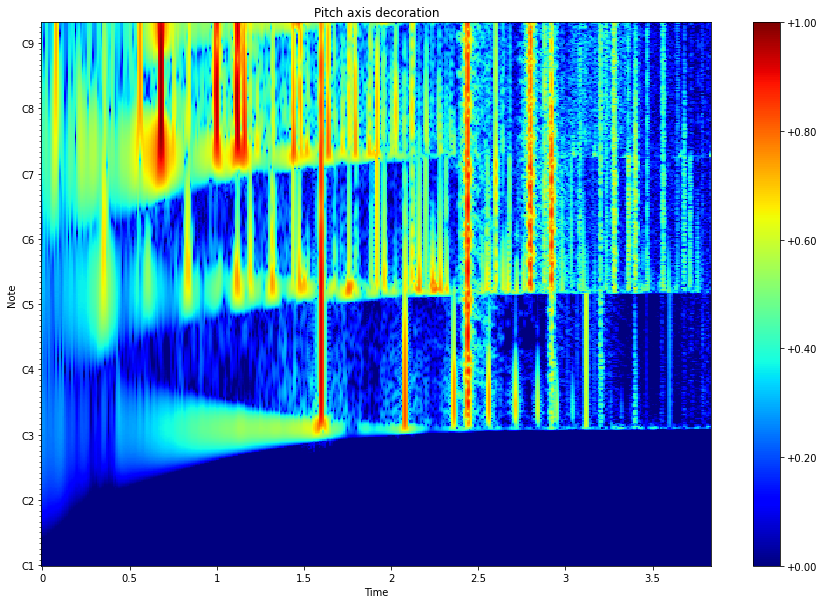

In [58]:
show_cqt(x.numpy())

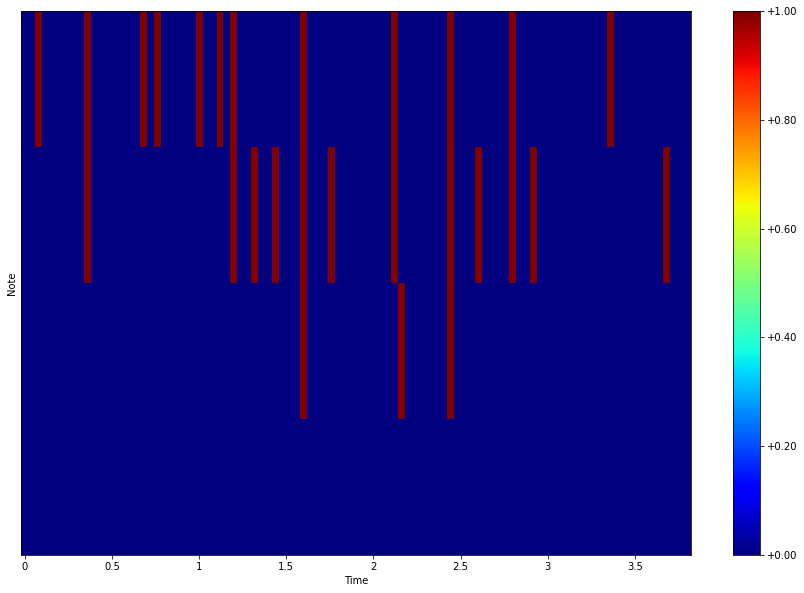

In [59]:
show_pr(y.numpy())

# model train

## data ready

In [60]:
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# traning

In [61]:
model_path = Path('./checkpoint/')
model_path.mkdir(parents=True, exist_ok=True)

In [62]:
train_step = len(train_ds)/BATCH_SIZE
val_step = len(val_ds)/BATCH_SIZE

early_stop_point = tf.keras.callbacks.EarlyStopping(
    patience=50
)
check_point = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(model_path,"best_model"),
    verbose=True,
    save_best_only=True,
)

model.fit(
    configure_for_performance(train_ds),
    steps_per_epoch=train_step,
    validation_data=configure_for_performance(val_ds),
    validation_steps=val_step,
    epochs=1000,
    callbacks=[early_stop_point,check_point]
)

Epoch 1/1000
90/90 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.5768
Epoch 1: val_loss improved from inf to 0.93954, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 55s 478ms/step - loss: 0.7206 - accuracy: 0.5768 - val_loss: 0.9395 - val_accuracy: 0.0377
Epoch 2/1000
90/90 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7480
Epoch 2: val_loss improved from 0.93954 to 0.90005, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 451ms/step - loss: 0.5787 - accuracy: 0.7480 - val_loss: 0.9001 - val_accuracy: 0.1854
Epoch 3/1000
90/90 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8504
Epoch 3: val_loss improved from 0.90005 to 0.77445, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_mod

Epoch 27/1000
90/90 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9783
Epoch 27: val_loss improved from 0.44504 to 0.40780, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 454ms/step - loss: 0.1660 - accuracy: 0.9783 - val_loss: 0.4078 - val_accuracy: 0.8091
Epoch 28/1000
90/90 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9783
Epoch 28: val_loss improved from 0.40780 to 0.37585, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 455ms/step - loss: 0.1608 - accuracy: 0.9783 - val_loss: 0.3758 - val_accuracy: 0.8376
Epoch 29/1000
90/90 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9783
Epoch 29: val_loss did not improve from 0.37585
90/90 [==============================] - 39s 429ms/step - loss: 0.1550 - accuracy: 0.97

Epoch 53/1000
90/90 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9805
Epoch 53: val_loss did not improve from 0.17396
90/90 [==============================] - 39s 431ms/step - loss: 0.0838 - accuracy: 0.9805 - val_loss: 0.1811 - val_accuracy: 0.9407
Epoch 54/1000
90/90 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9804
Epoch 54: val_loss improved from 0.17396 to 0.16268, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 453ms/step - loss: 0.0828 - accuracy: 0.9804 - val_loss: 0.1627 - val_accuracy: 0.9530
Epoch 55/1000
90/90 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9806
Epoch 55: val_loss improved from 0.16268 to 0.15423, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 455ms/step - loss: 0.0815 - accuracy: 0.98

90/90 [==============================] - 39s 430ms/step - loss: 0.0667 - accuracy: 0.9817 - val_loss: 0.2273 - val_accuracy: 0.9076
Epoch 82/1000
90/90 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9817
Epoch 82: val_loss did not improve from 0.14231
90/90 [==============================] - 38s 429ms/step - loss: 0.0667 - accuracy: 0.9817 - val_loss: 0.3469 - val_accuracy: 0.8277
Epoch 83/1000
90/90 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9818
Epoch 83: val_loss improved from 0.14231 to 0.13096, saving model to checkpoint\best_model
INFO:tensorflow:Assets written to: checkpoint\best_model\assets
90/90 [==============================] - 41s 452ms/step - loss: 0.0663 - accuracy: 0.9818 - val_loss: 0.1310 - val_accuracy: 0.9691
Epoch 84/1000
90/90 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9818
Epoch 84: val_loss did not improve from 0.13096
90/90 [==============================] - 39s 428ms/step - loss

90/90 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9828
Epoch 110: val_loss did not improve from 0.12866
90/90 [==============================] - 39s 430ms/step - loss: 0.0605 - accuracy: 0.9828 - val_loss: 0.2401 - val_accuracy: 0.8907
Epoch 111/1000
90/90 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9829
Epoch 111: val_loss did not improve from 0.12866
90/90 [==============================] - 39s 430ms/step - loss: 0.0603 - accuracy: 0.9829 - val_loss: 0.1458 - val_accuracy: 0.9616
Epoch 112/1000
90/90 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9828
Epoch 112: val_loss did not improve from 0.12866
90/90 [==============================] - 39s 431ms/step - loss: 0.0602 - accuracy: 0.9828 - val_loss: 0.1449 - val_accuracy: 0.9610
Epoch 113/1000
90/90 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9829
Epoch 113: val_loss did not improve from 0.12866
90/90 [========================

In [63]:
def show_3(cqt,pr,pred):
    show_list = [cqt,pr,pred]
    for i,s in enumerate(show_list):
        if s.ndim == 3:
            show_list[i] = np.squeeze(s,-1)
        elif s.ndim == 4:
            show_list[i] = np.squeeze(s,(0,-1))
    
    fig, ax = plt.subplots(1,3,figsize=(15,10))
    img0 = librosa.display.specshow(
        show_list[0].T, sr=sr,
        x_axis='time',
        y_axis='cqt_note',
        ax=ax[0],
        hop_length= hop_len,
        bins_per_octave= 12*freq_w,
        cmap='jet'
    )
    ax[0].set(title='constant-Q Transform')
    fig.colorbar(img0, ax=ax[0], format="%+2.2f")
    
    img1 = librosa.display.specshow(
        show_list[1].T,
        hop_length=1,
        sr=fs,
        ax=ax[1],
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    )
    ax[1].set(title='Piano roll form')
    fig.colorbar(img1, ax=ax[1], format="%+2.2f")
    
    img2 = librosa.display.specshow(
        show_list[2].T,
        hop_length=1,
        sr=fs,
        ax=ax[2],
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    )
    ax[2].set(title='Predict Piano roll form')
    fig.colorbar(img2, ax=ax[2], format="%+2.2f")
    plt.show()

In [64]:
model = tf.keras.models.load_model('./checkpoint/best_model')
# model.evaluate(val_ds)

C:\Users\AI_server\miniconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


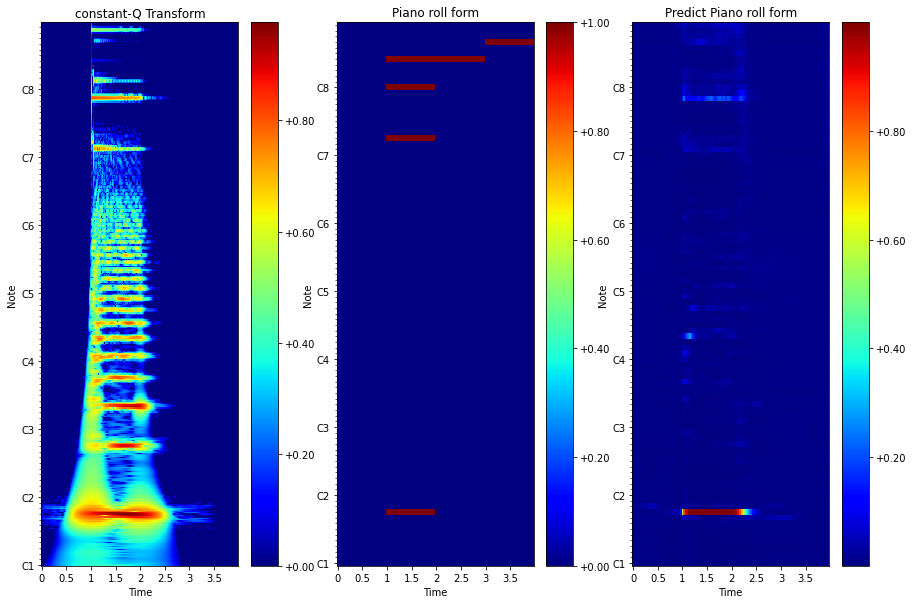

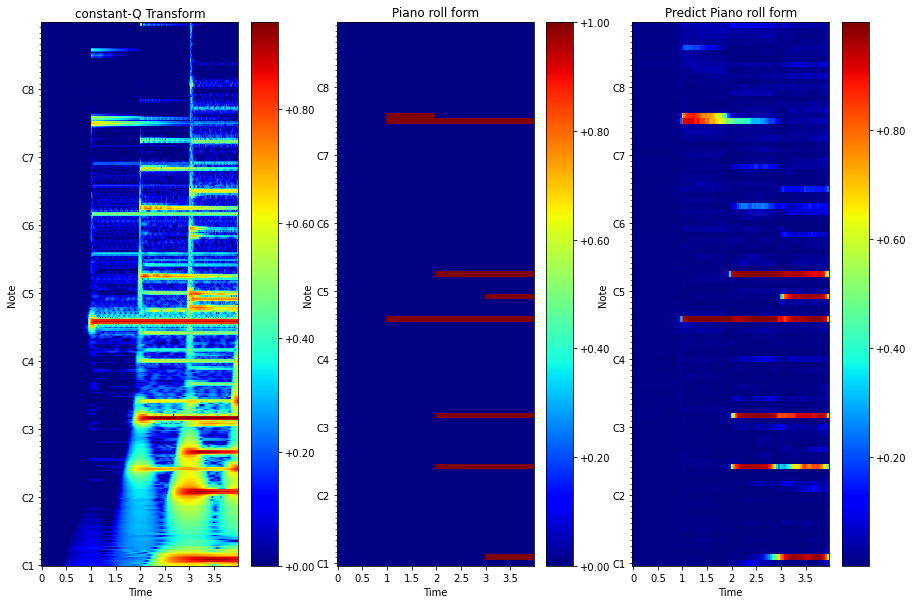

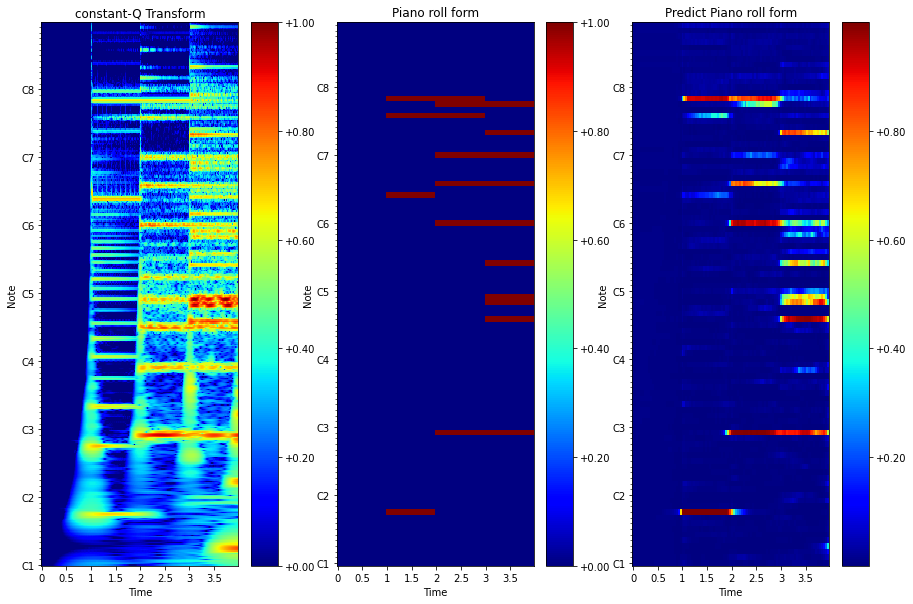

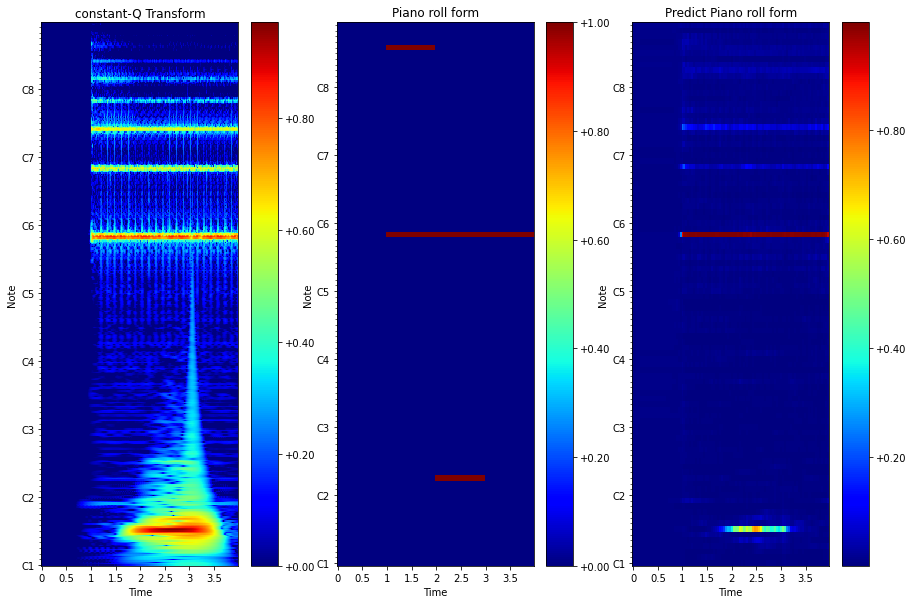

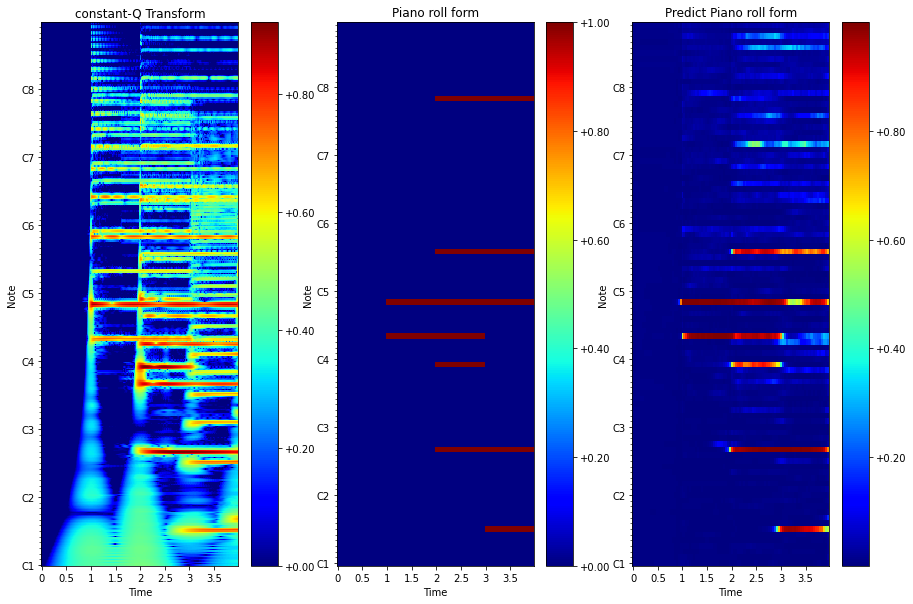

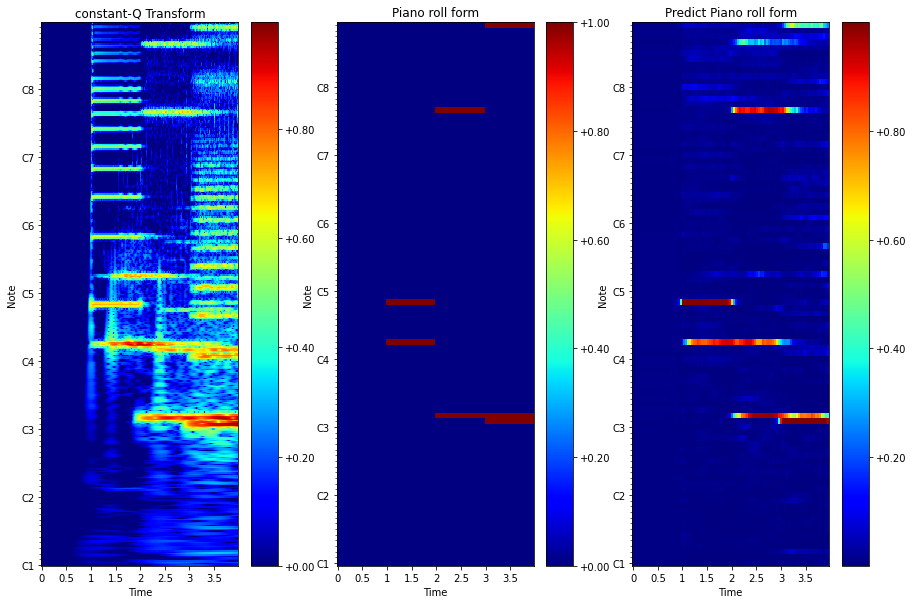

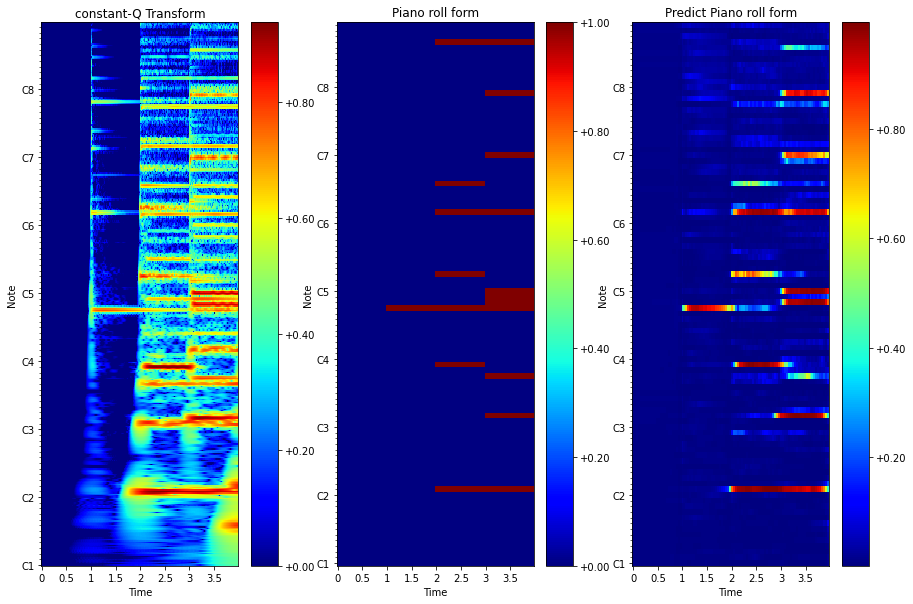

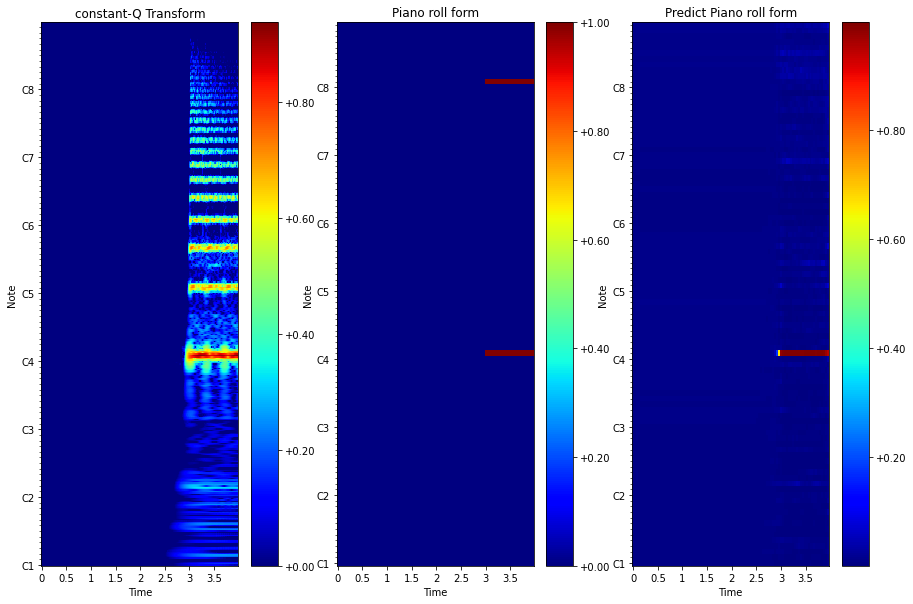

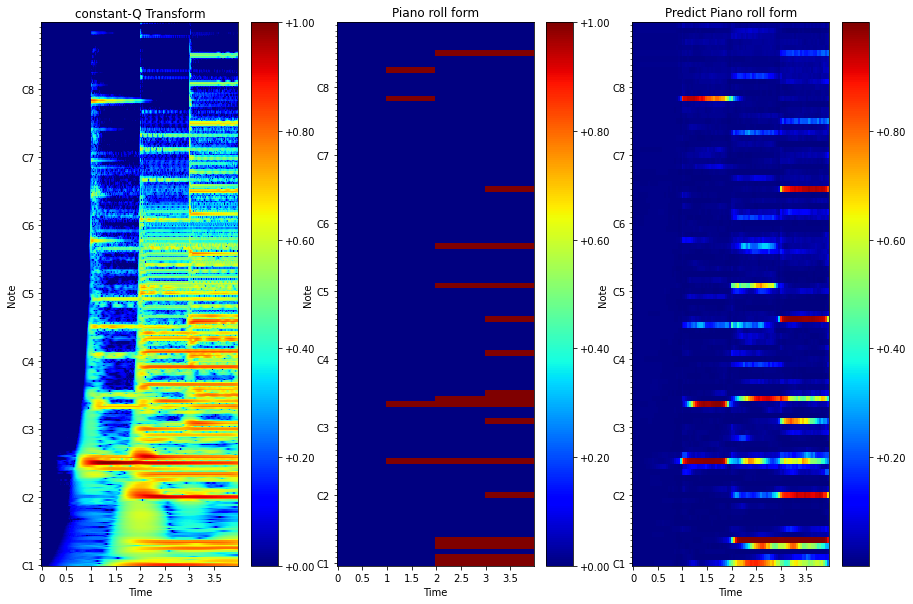

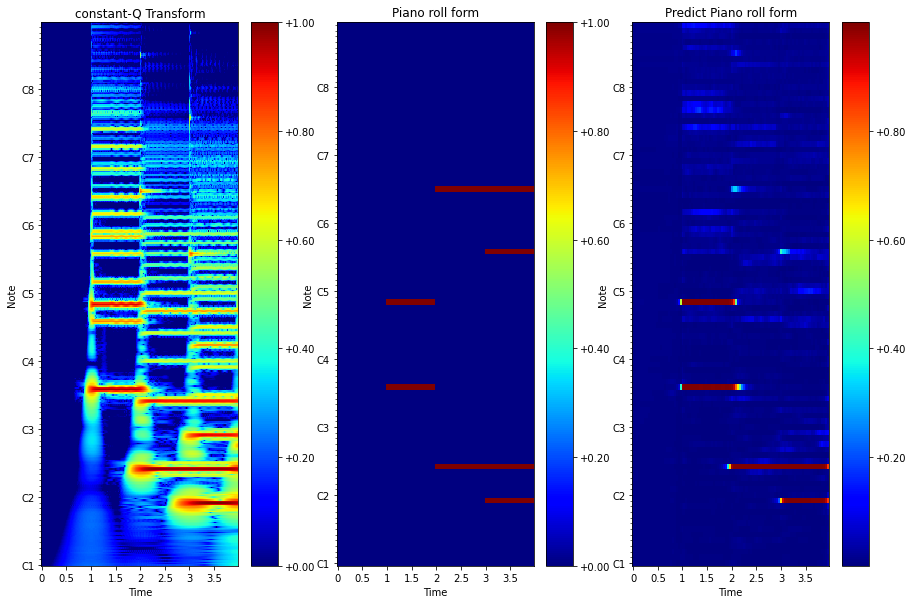

In [65]:
for cqt,pr in val_ds.take(10):
    pred = model.predict(cqt[tf.newaxis])
    show_3(cqt,pr,pred)